In [286]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, \
    PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.decomposition import PCA
import calendar

Вспомогательные функции

In [242]:
#  Функция фильтраци выбросов
def outliersData(data, column):
    quantile_3 = data.query('sample == 1')[column].quantile(0.75)
    quantile_1 = data.query('sample == 1')[column].quantile(0.25)
    if quantile_3 == quantile_1:
        return data

    IQR = quantile_3 - quantile_1
    column_min = quantile_1 - 1.5 * IQR
    column_max = quantile_3 + 1.5 * IQR

    count_element_out = data.query('sample == 1')[(data[column] >= column_max) & (data[column] <= column_min)][
        column].count()

    print('Q1 - {} . Q3 - {}. Нижняя граница: {}. Вверхняя граница: {}. Количество элементов за границами: {}'.format(
        round(quantile_1, 2), round(quantile_3, 2), round(column_min, 2), round(column_max, 2), count_element_out
    ))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title(' Распределение параметра ' + column)
    sns.distplot(data[column], ax=axes[0])
    axes[1].set_title(' Параметр ' + column + ' от целевой переменной')
    sns.boxplot(x='default', y=data[column], data=data, orient='v', ax=axes[1])

    data = data[data[column].between(column_min, column_max)]
    return data


# Функция замены на самое частое значение
def replaceValue(data, columns):
    for column in columns:
        max_ = data[column].value_counts().idxmax()
        data[column] = data[column].apply(
            lambda x: max_ if pd.isnull(x) else (max_ if (x == 'nan' or x.strip() == '') else x))
    return data


# Функция масштабирования признака от 0 до 1
def Max_min_scalar(data, columns, default='default'):
    scaler = MinMaxScaler()
    cor_before = data.query('sample == 1')[columns].corr(data[default])
    data[columns] = scaler.fit_transform(data[[columns]])
    cor_after = data.query('sample == 1')[columns].corr(data[default])
    print('Колонка - {}. Корреляция до масштабирования  - {}. Корреляция после масштабирования - {}'.format(
        columns, round(cor_before, 2), round(cor_after, 2)
    ))
    return data

# Логарифмирование
def logNumberValue(data, columns, default='default'):
    for column in columns:
        cor_before = data.query('sample == 1')[column].corr(data[default])
        data[column] = data[column].apply(lambda w: np.log(w + 1))
        cor_after = data.query('sample == 1')[column].corr(data[default])
        print('Колонка - {}. Корреляция до лограмирования: {}. Корреляция после лограмирования: {}'.format(
            column, round(cor_before, 2), round(cor_after, 2)
        ))

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].set_title(' Распределение параметра ' + column)
        sns.distplot(data[column], ax=axes[0])
        axes[1].set_title(' Параметр ' + column + ' от целевой переменной')
        sns.boxplot(x='default', y=data[column], data=data, orient='v', ax=axes[1])
    return data

### Загрузка данных

In [243]:
df_train = pd.read_csv('./data/train.csv')
df_test= pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [244]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [246]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

<AxesSubplot:>

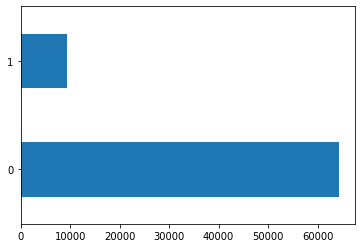

In [247]:
data.query('sample == 1')['default'].value_counts().plot.barh()

In [248]:
data.query('sample == 1')['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Соотношение 1 к 10 не выполняется. Не будем сокращать выборку! 

## Числовые характеристики
Перечислим колонки по типам и будем их обрабатывать отдельно

In [249]:
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'region_rating', 'first_time']

bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

cat_cols=['education','home_address','work_address','app_date','sna'] 

target = ['default']

In [250]:
data = Max_min_scalar(data, 'score_bki' )

Колонка - score_bki. Корреляция до масштабирования  - 0.18. Корреляция после масштабирования - 0.18


Масштабирование колонки не привело к изменению корреляции с целевой переменной! 

Колонка - age. Корреляция до лограмирования: -0.03. Корреляция после лограмирования: -0.03


c:\study\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Колонка - decline_app_cnt. Корреляция до лограмирования: 0.11. Корреляция после лограмирования: 0.12


c:\study\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Колонка - income. Корреляция до лограмирования: -0.04. Корреляция после лограмирования: -0.05


c:\study\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Колонка - bki_request_cnt. Корреляция до лограмирования: 0.08. Корреляция после лограмирования: 0.08


c:\study\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Колонка - score_bki. Корреляция до лограмирования: 0.18. Корреляция после лограмирования: 0.17


c:\study\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Колонка - region_rating. Корреляция до лограмирования: -0.09. Корреляция после лограмирования: -0.09


c:\study\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Колонка - first_time. Корреляция до лограмирования: -0.11. Корреляция после лограмирования: -0.1


c:\study\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


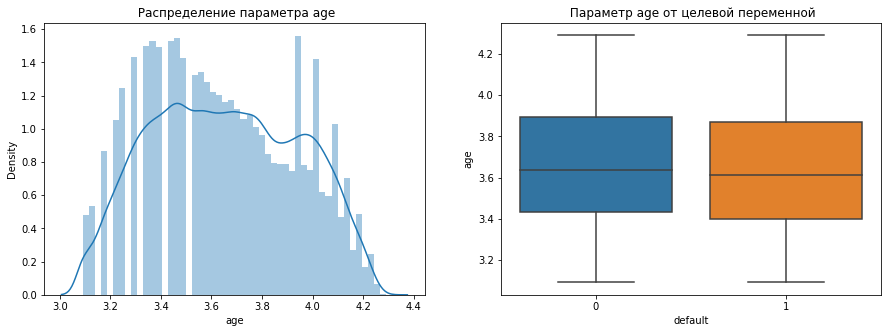

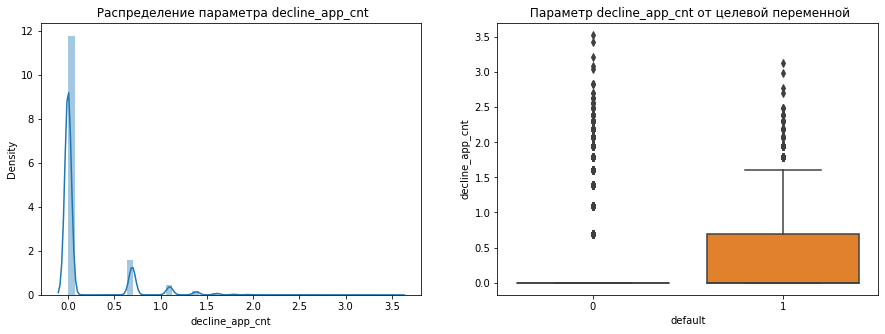

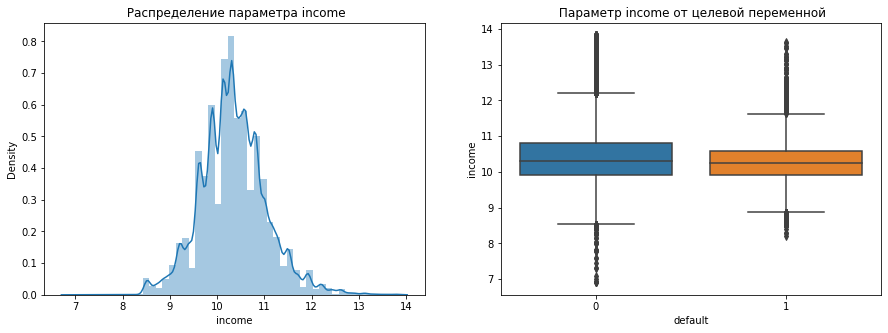

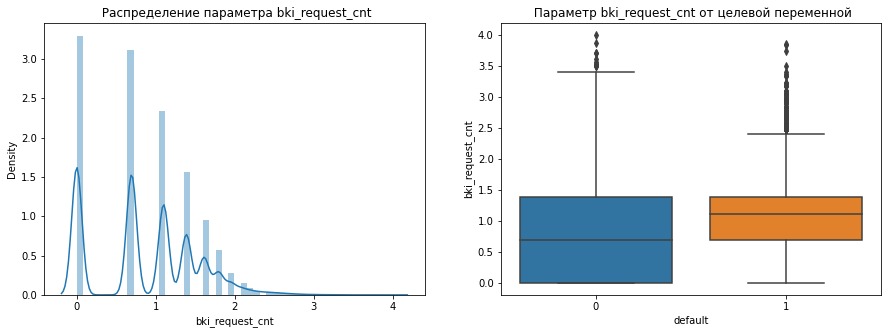

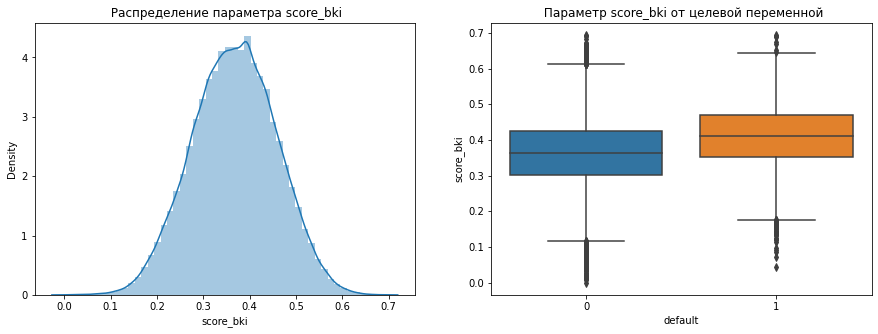

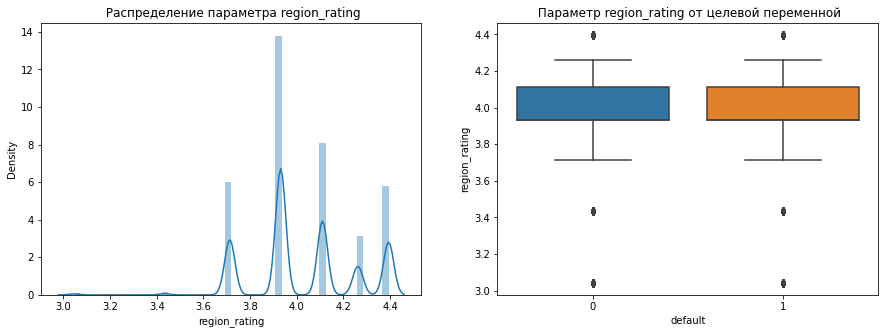

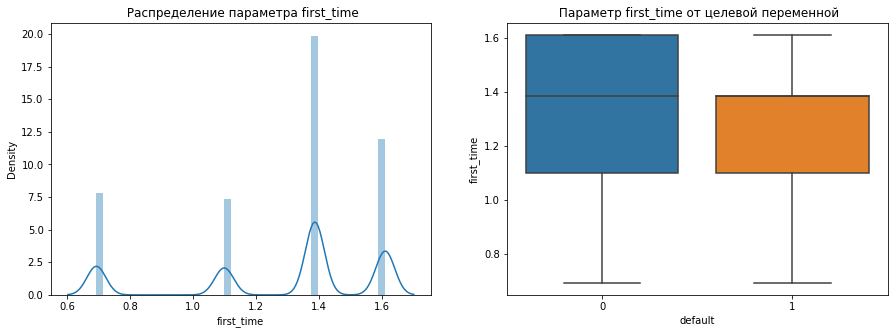

In [251]:
data = logNumberValue(data, num_cols)

### Анализ коэффицинетов корреляции

Колонка - age. Корреляция до лограмирования: -0.03. Корреляция после лограмирования: -0.03

Колонка - decline_app_cnt. Корреляция до лограмирования: 0.11. Корреляция после лограмирования: 0.12

Колонка - income. Корреляция до лограмирования: -0.04. Корреляция после лограмирования: -0.05

Колонка - bki_request_cnt. Корреляция до лограмирования: 0.08. Корреляция после лограмирования: 0.08

Колонка - score_bki. Корреляция до лограмирования: 0.18. Корреляция после лограмирования: 0.17

Колонка - region_rating. Корреляция до лограмирования:  -0.09. Корреляция после лограмирования: -0.09

Колонка - first_time. Корреляция до лограмирования: -0.11. Корреляция после лограмирования: -0.1

### Видно по результату , что корреляция  изменилась незначительно.


### Поиск выбросов 
Как показал предварительный анализ - выбросов нет 

In [252]:

# for col in num_cols:
#     data = outliersData(data, col)

Влияние числовых признаков на целевой показатель:

<AxesSubplot:>

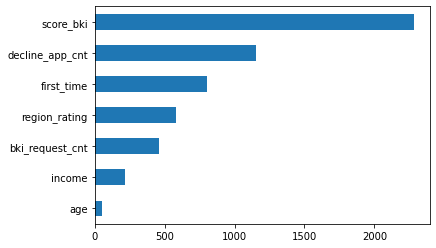

In [253]:
imp_num = pd.Series(f_classif(data.query('sample == 1')[num_cols], data.query('sample == 1')['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [254]:
imp_num

age                  50.380574
income              214.790527
bki_request_cnt     457.591760
region_rating       580.216057
first_time          803.272041
decline_app_cnt    1152.937317
score_bki          2281.580737
dtype: float64

<AxesSubplot:>

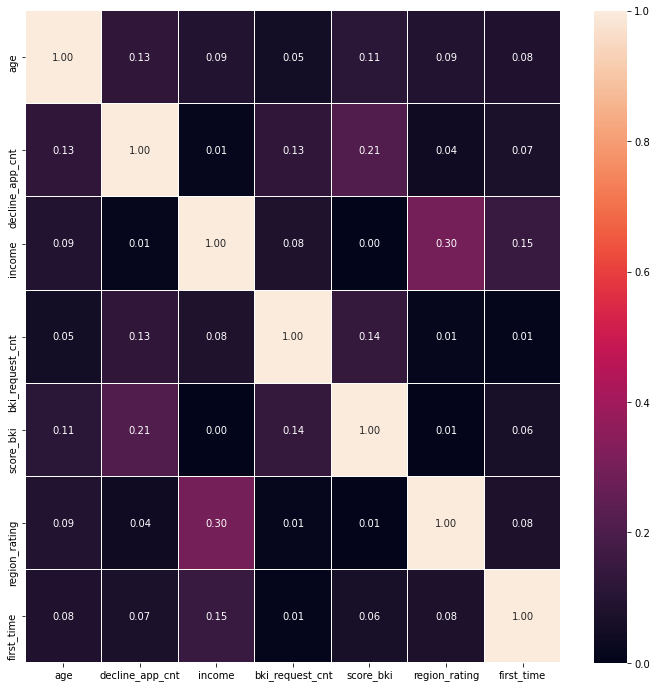

In [255]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(data.query('sample == 1')[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=0.1)

In [256]:
data.query('sample == 1')[num_cols + target].corr()['default']

age               -0.026119
decline_app_cnt    0.124027
income            -0.053871
bki_request_cnt    0.078501
score_bki          0.173176
region_rating     -0.088323
first_time        -0.103767
default            1.000000
Name: default, dtype: float64

### Все числовые переменные некоррелированы! Наблюдается слабая корреляция между числовыми переменными и целевым признаков. 

### Попробуем поискать сочитанием числовых колонок, найдем те которые влияют на целевую характеристику! 

In [257]:
num_cols

['age',
 'decline_app_cnt',
 'income',
 'bki_request_cnt',
 'score_bki',
 'region_rating',
 'first_time']

In [258]:
def PolimicFeatre(data, num_cols):
    poly = PolynomialFeatures(3)
    ppl_data = poly.fit_transform(data[num_cols])
    poly_name = poly.get_feature_names()

    dictionary = {}
    i = 0
    for col in num_cols:
        dictionary['x' + str(i).strip()] = col.strip()
        i += 1

    dictionary_seed = {}
    for col in poly_name:
        col_seed = col
        for k, v in dictionary.items():
            col = col.replace(str(k), str(v))
        dictionary_seed[col_seed] = col

    ppl_data = pd.DataFrame(data=ppl_data, columns=poly_name)
    ppl_data.rename(columns=dictionary_seed, inplace=True)

    num_cols_del = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'region_rating', 'first_time',
                    '1']
    ppl_data.drop(num_cols_del, axis=1, inplace=True)

    data = data.join(ppl_data, how='left')

    ppl_data_col = ppl_data.columns.to_list()
    num_cols = num_cols + ppl_data_col

    fig, ax = plt.subplots(figsize=(12, 12))
    imp_num = pd.Series(f_classif(data.query('sample == 1')[num_cols], data.query('sample == 1')['default'])[0],
                        index=num_cols)
    imp_num.sort_values(inplace=True, ascending=False)
    imp_num.plot(kind='barh')

    # возьмем 75% самых важных признаков
    num_select = imp_num[imp_num.values >= (imp_num.max() * 0.25)].keys()
    num_drob = imp_num[imp_num.values < (imp_num.max() * 0.25)].keys()
    data.drop(num_drob, axis=1, inplace=True)
    num_cols = num_select.to_list()
    data.columns = data.columns.str.strip()
    return  data, num_cols

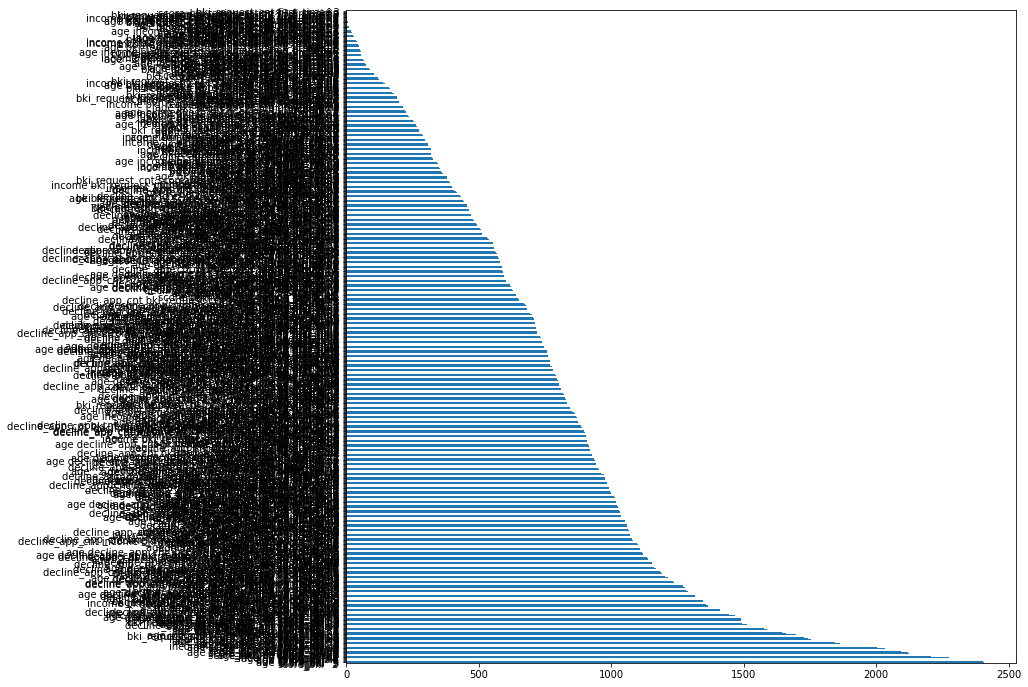

In [259]:
data, num_cols = PolimicFeatre(data, num_cols)

<AxesSubplot:>

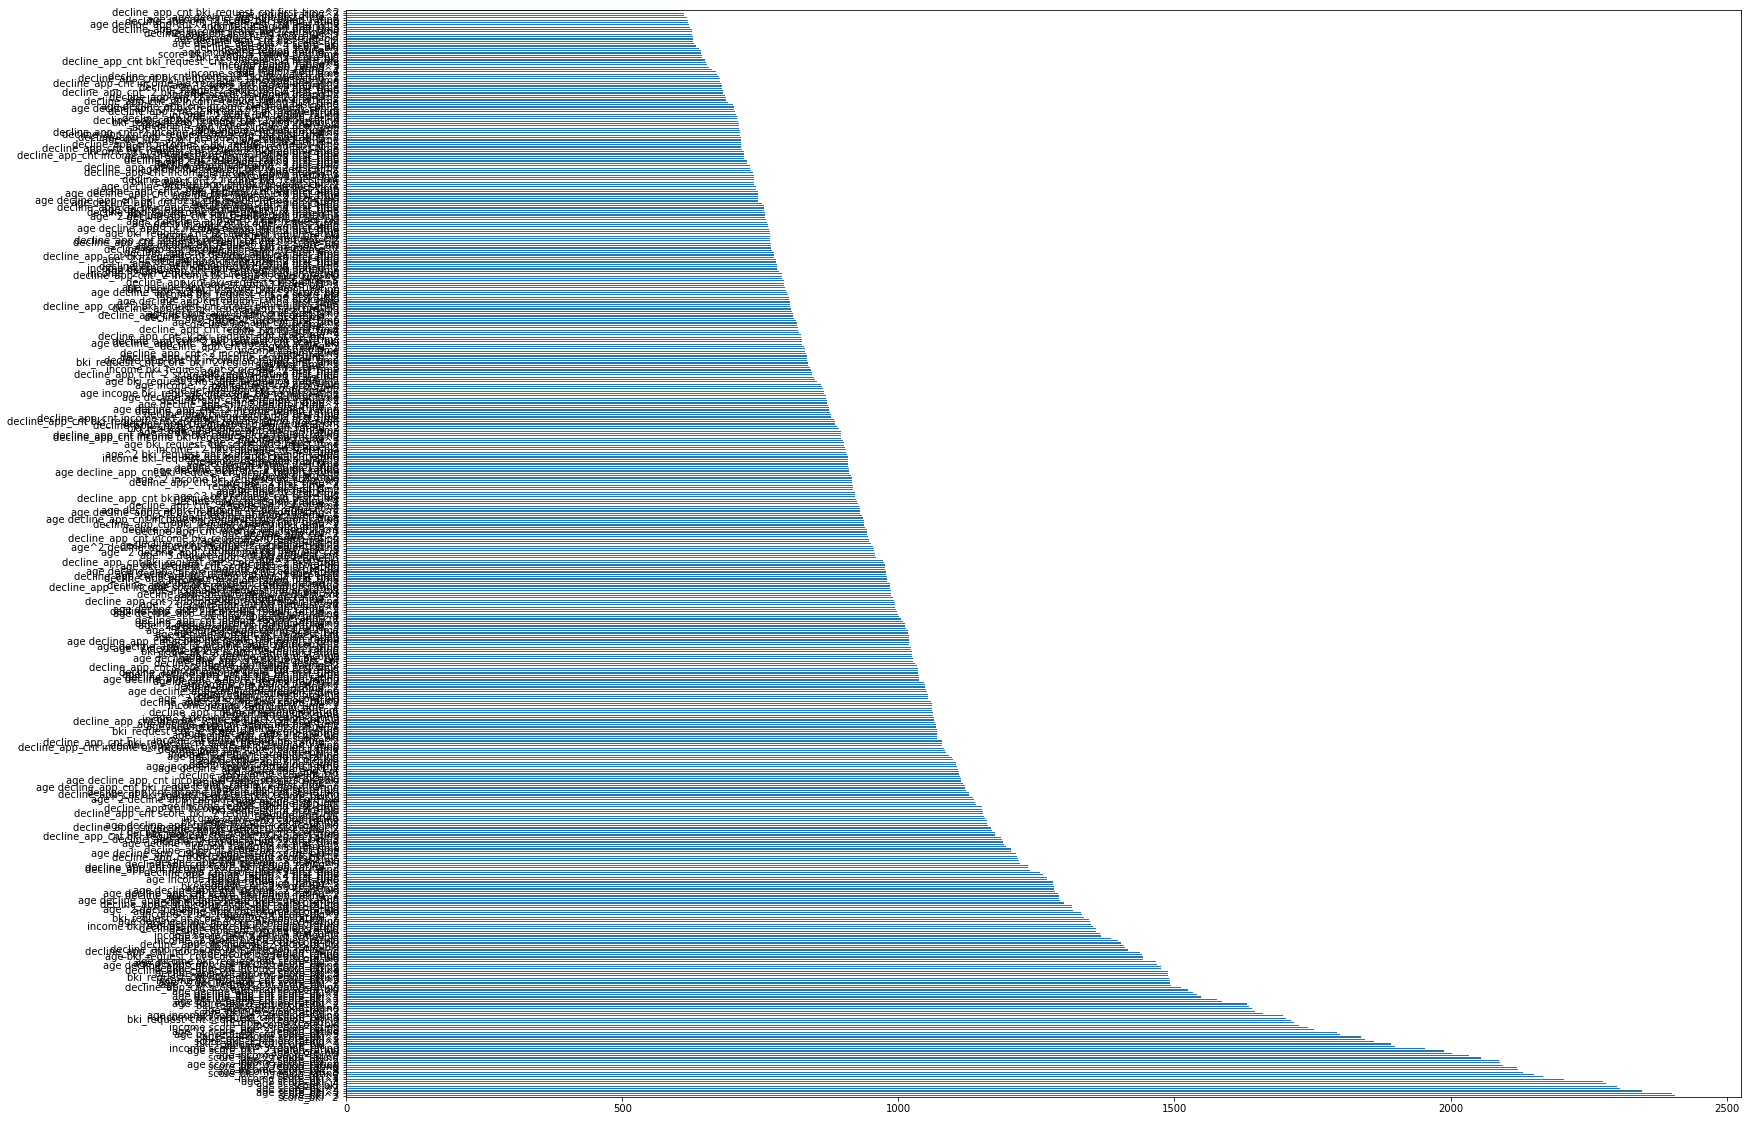

In [260]:
fig, ax = plt.subplots(figsize=(25,20)) 
imp_num = pd.Series(f_classif(data.query('sample == 1')[num_cols], data.query('sample == 1')['default'])[0],
                        index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind='barh')

<AxesSubplot:>

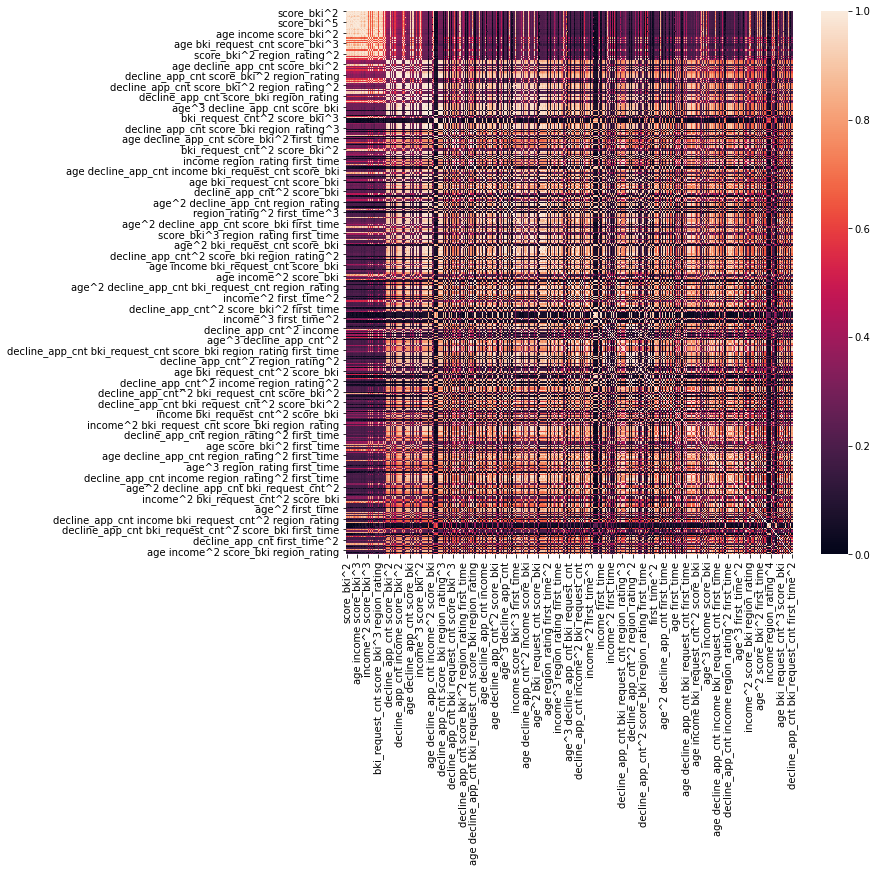

In [261]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data.query('sample == 1')[num_cols].corr().abs(), vmin=0, vmax=1)

In [262]:
data.query('sample == 1')[num_cols + target].corr()['default']

score_bki^2                                     0.177692
score_bki^3                                     0.177541
age score_bki^3                                 0.175585
score_bki^4                                     0.174110
age score_bki^2                                 0.173897
                                                  ...   
age income^2 score_bki region_rating            0.091071
age decline_app_cnt first_time^2                0.090698
age region_rating^2                            -0.090621
decline_app_cnt bki_request_cnt first_time^2    0.090047
default                                         1.000000
Name: default, Length: 464, dtype: float64

<AxesSubplot:>

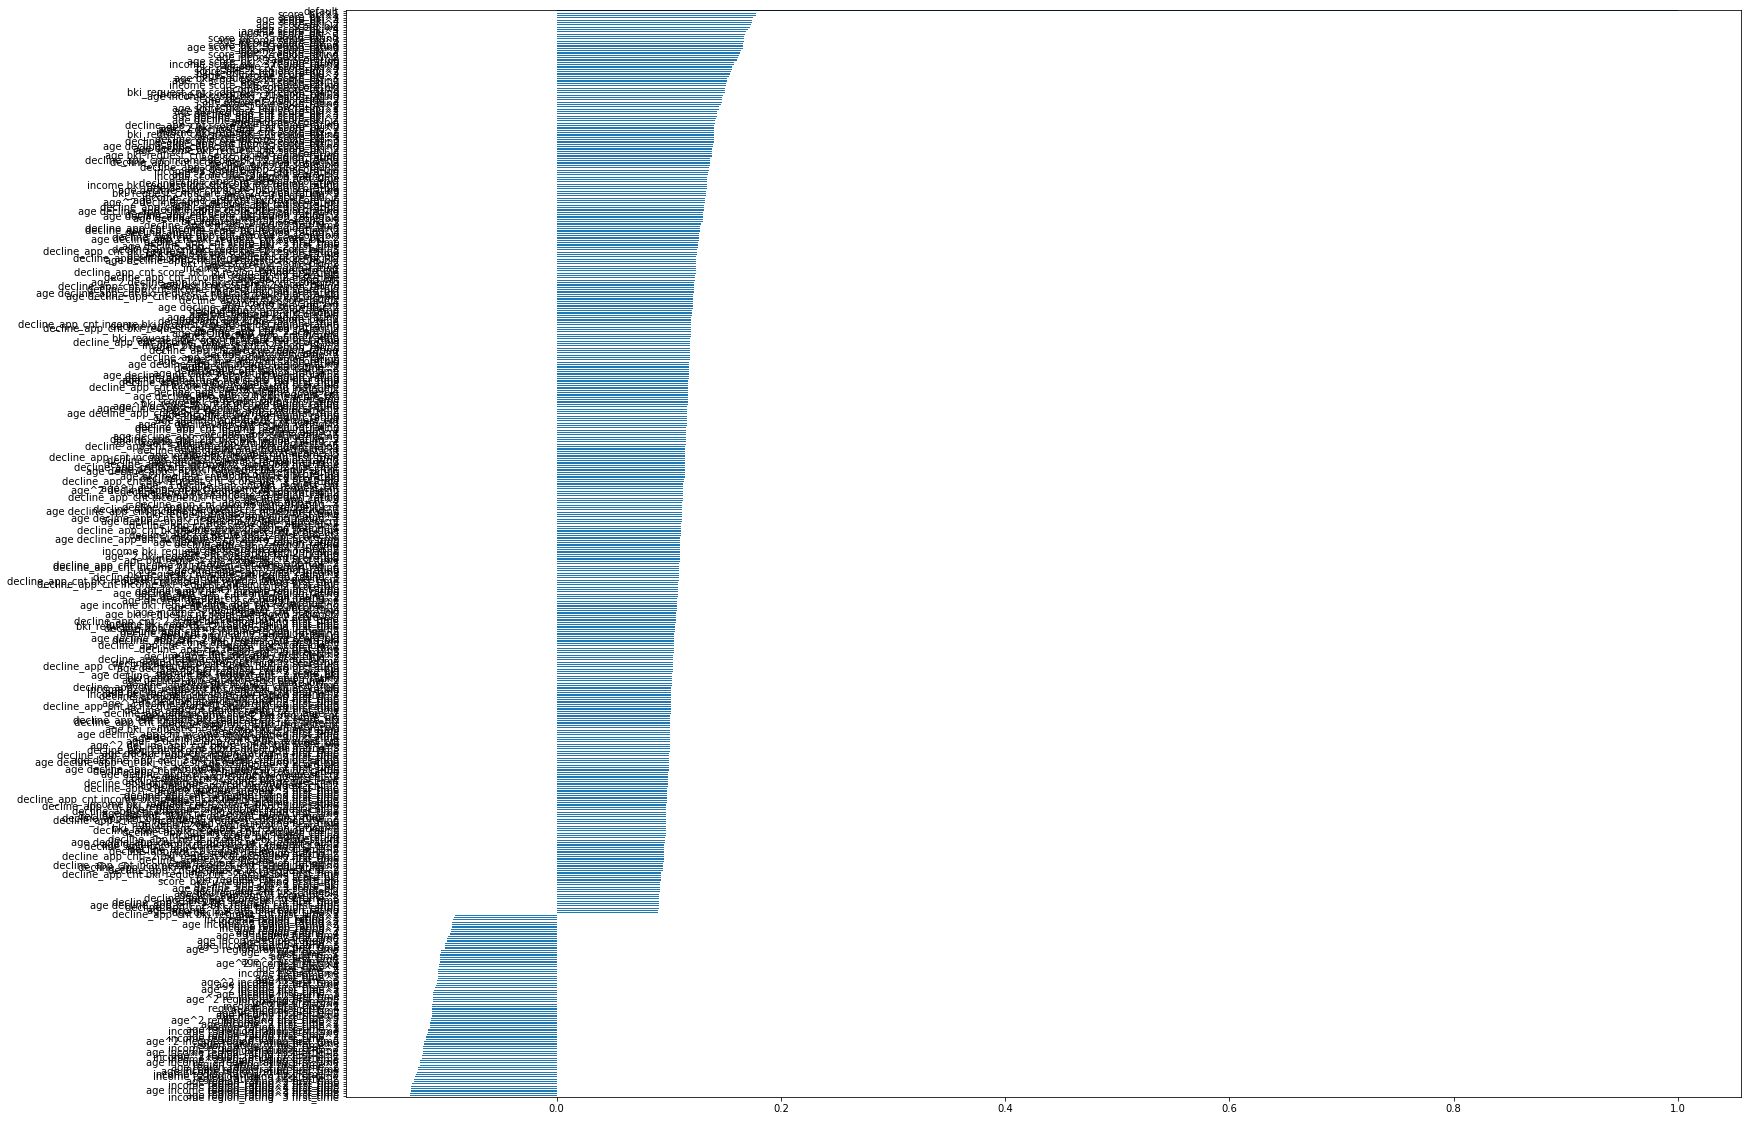

In [263]:
fig, ax = plt.subplots(figsize=(25,20))
num_rocc =data.query('sample == 1')[num_cols + target].corr()['default'].sort_values()
num_rocc.plot(kind='barh')

Корреляция между целеым показателем и числовыми признаками небольшая. Вообще тут можно стравнить разные числовы признаки и почистить их , объединяя признаки с высокой корреляцией. 

# БИНАРНЫЕ ПРИЗНАКИ

In [264]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

Корреляция с целевым показателем

In [265]:
bin_cor = data.query('sample == 1')[bin_cols + target].corr()['default'].sort_values()
bin_cor

foreign_passport   -0.066718
car_type           -0.057484
good_work          -0.043361
car                -0.043161
sex                 0.019619
default             1.000000
Name: default, dtype: float64

<AxesSubplot:>

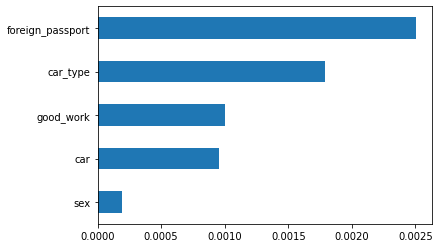

In [266]:
bin_cat = Series(mutual_info_classif(data.query('sample == 1')[bin_cols], data.query('sample == 1')['default'],
                                     discrete_features=True), index=bin_cols)
bin_cat.sort_values(inplace=True)
bin_cat.plot(kind='barh')

<AxesSubplot:>

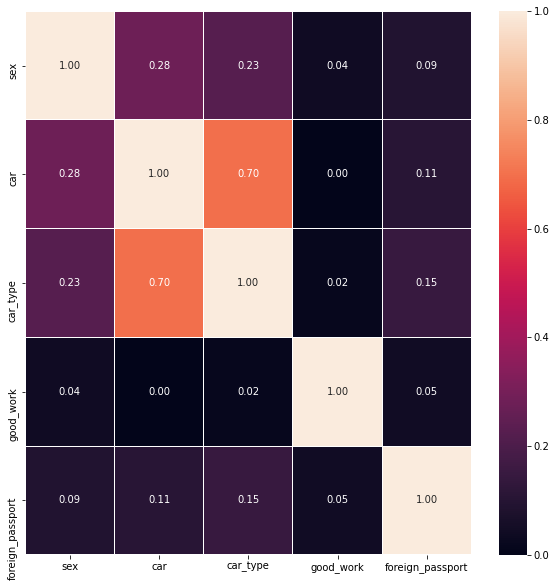

In [267]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data.query('sample == 1')[bin_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=0.1)

Видна сильная связь между признаками car_type и car.
Объединим эти два признака в один посредством метода гланых компонент.

In [268]:

date_pca = data[['car_type', 'car']]
data.drop(['car_type', 'car'], axis=1, inplace=True)
pca = PCA(n_components=1)
date_pca_ = pca.fit_transform(date_pca)
data['car_type_car'] = date_pca_
data['car_type_car'] = data['car_type_car'].round(6)

bin_cols = ['sex', 'car_type_car', 'good_work', 'foreign_passport']

<AxesSubplot:>

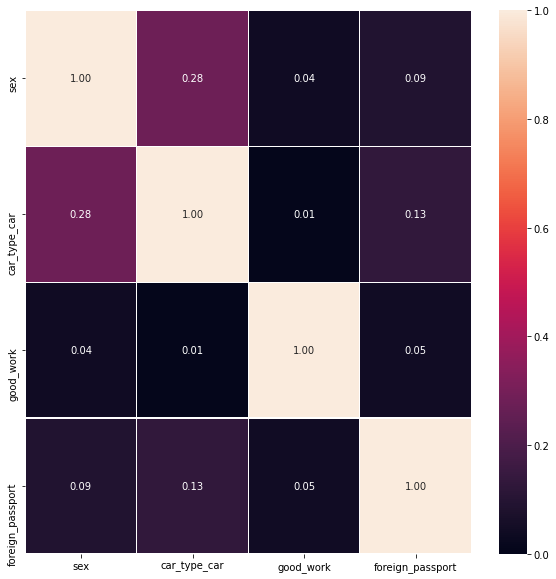

In [269]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data.query('sample == 1')[bin_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=0.1)

c:\study\venv\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

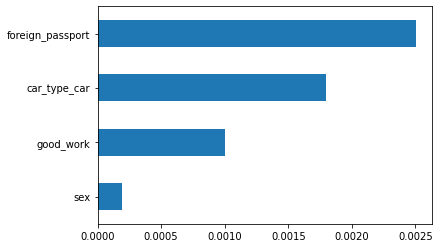

In [270]:
bin_cat = Series(mutual_info_classif(data.query('sample == 1')[bin_cols], data.query('sample == 1')['default'],
                                     discrete_features=True), index=bin_cols)
bin_cat.sort_values(inplace=True)
bin_cat.plot(kind='barh')

# Категориальные признаки
пропуски в признаке образование / школу должны уж закончить

In [271]:
data = replaceValue(data, ['education'])

In [272]:
# подачи заявки  - примем как категориальный признак (название месяца)
import calendar
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date']  = data['app_date'] .apply(lambda x: calendar.month_name[x.month])

In [273]:
# get_dummies переменные - удалим старые столбцы
data = pd.get_dummies(data, columns=cat_cols)

<AxesSubplot:>

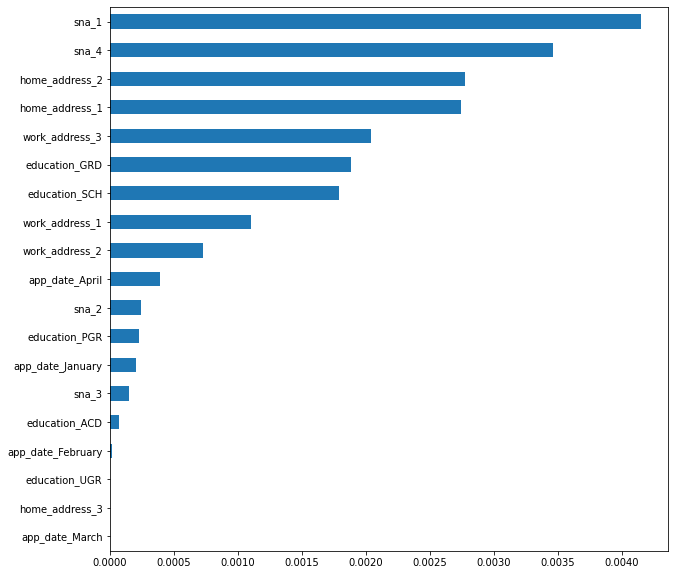

In [274]:
#  влияние категориальных переменных на целевой признак
cat_cols = ['education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR', 'home_address_1', 'home_address_2', 'home_address_3',
       'work_address_1', 'work_address_2', 'work_address_3', 'app_date_April',
       'app_date_February', 'app_date_January', 'app_date_March', 'sna_1',
       'sna_2', 'sna_3', 'sna_4']
fig, ax = plt.subplots(figsize=(10,10)) 
imp_cat = Series(mutual_info_classif(data[cat_cols], data['default'],
                                     discrete_features =True), index =cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

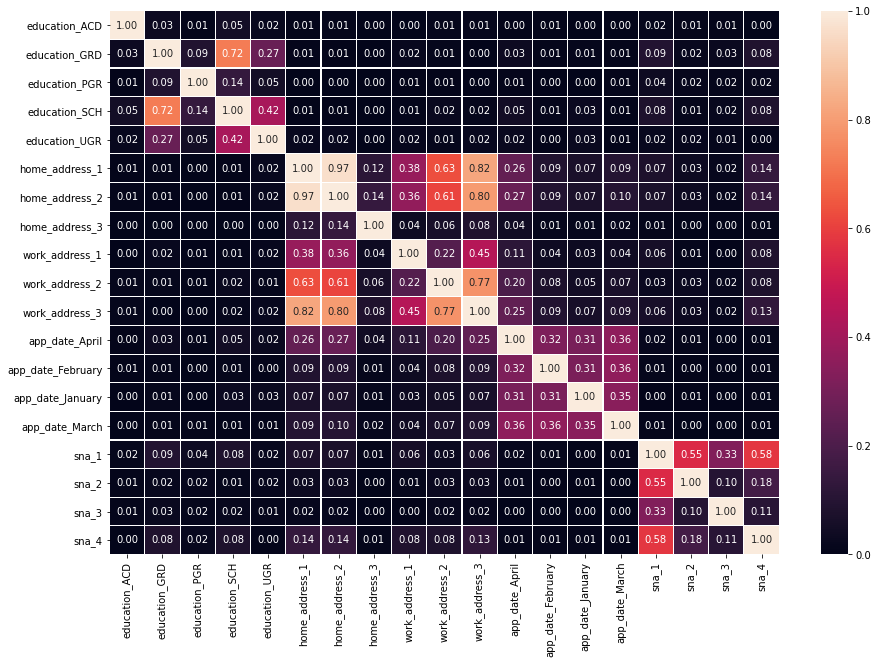

In [275]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(data.query('sample == 1')[cat_cols].corr().abs(), vmin=0, vmax=1,annot=True, fmt=".2f", linewidths=0.1)

В целом видны зависимости некторых категориальных переменных. 

Попробуем объединить некторые из столбцов

In [276]:
def cat_variable_corr(data, col):
    # Поочередно объединим некторые параметры - редактируя при этом колонки
    # education_SCH vs education_GRD
    date_pca = data[['education_SCH', 'education_GRD']]
    data.drop(['education_SCH', 'education_GRD'], axis=1, inplace=True)
    pca = PCA(n_components=1)
    date_pca_ = pca.fit_transform(date_pca).round(6)
    data['education_SCH_GRD'] = date_pca_

    col = list(set(col) - {'education_SCH', 'education_GRD'})
    col.append('education_SCH_GRD')

    # home_address_1 vs home_address_2
    date_pca = data[['home_address_1', 'home_address_2']]
    data.drop(['home_address_1', 'home_address_2'], axis=1, inplace=True)
    pca = PCA(n_components=1)
    date_pca_ = pca.fit_transform(date_pca).round(6)
    data['home_address_1_2'] = date_pca_

    col = list(set(col) - {'home_address_1', 'home_address_2'})
    col.append('home_address_1_2')

    # work_address_2 vs work_address_3
    date_pca = data[['work_address_2', 'work_address_3']]
    data.drop(['work_address_2', 'work_address_3'], axis=1, inplace=True)
    pca = PCA(n_components=1)
    date_pca_ = pca.fit_transform(date_pca).round(6)
    data['work_address_2_3'] = date_pca_

    col = list(set(col) - {'work_address_2', 'work_address_3'})
    col.append('work_address_2_3')

    # home_address_1_2 vs work_address_2_3
    date_pca = data[['home_address_1_2', 'work_address_2_3']]
    data.drop(['home_address_1_2', 'work_address_2_3'], axis=1, inplace=True)
    pca = PCA(n_components=1)
    date_pca_ = pca.fit_transform(date_pca).round(6)
    data['home_address_1_2_work_address_2_3'] = date_pca_

    col = list(set(col) - {'home_address_1_2', 'work_address_2_3'})
    col.append('home_address_1_2_work_address_2_3')

    return data , col

In [277]:
data,cat_cols = cat_variable_corr(data, cat_cols)

<AxesSubplot:>

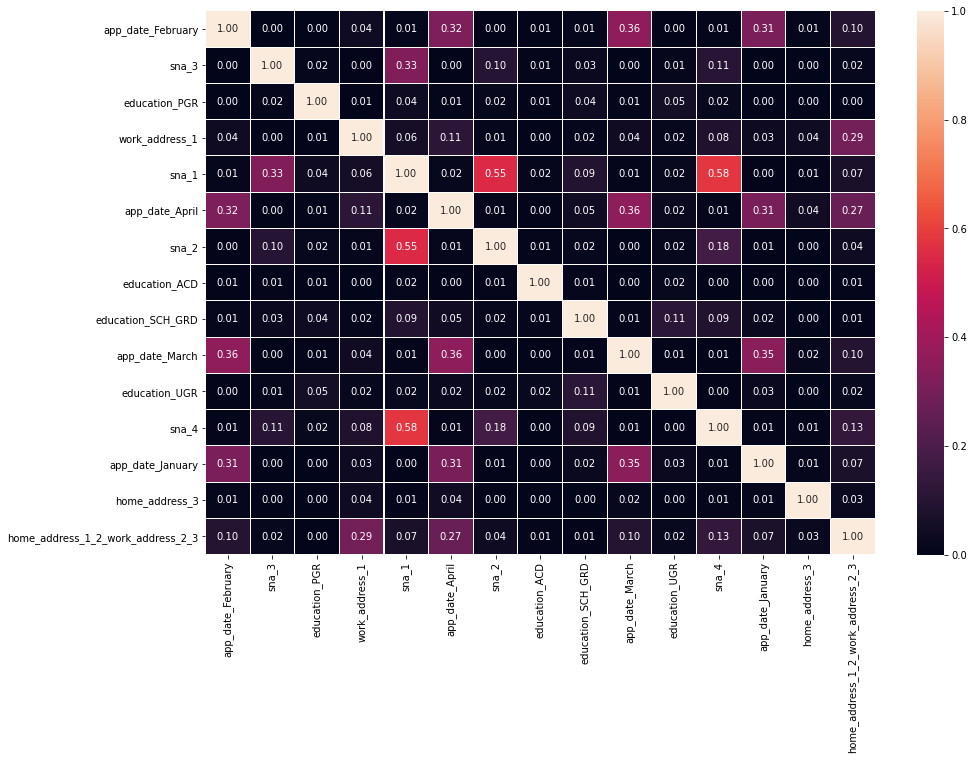

In [278]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(data.query('sample == 1')[cat_cols].corr().abs(), vmin=0, vmax=1,annot=True, fmt=".2f", linewidths=0.1)

# Обучение

In [279]:
X_num = StandardScaler().fit_transform(data[num_cols].values)
data[num_cols] = X_num

In [280]:
#  ОБУчение
X = np.hstack([data.query('sample == 1')[num_cols].values, data.query('sample == 1')[bin_cols].values,
               data.query('sample == 1')[cat_cols].values])
Y = data.query('sample == 1')['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=45)

In [281]:
# Гипер параметры
# penalty = ['l1', 'l2']
# C = np.logspace(0, 4, 10)
# hyperparameters = dict(C=C, penalty=penalty)

# model = LogisticRegression()
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
# best_model = clf.fit(X_train, y_train)

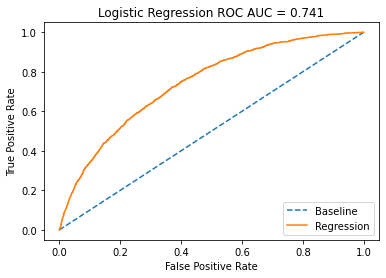

In [287]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', C=1.0, penalty='l2')
model.fit(X_train, y_train)
probs_ = model.predict(X_test)
pred_probs = model.predict_proba(X_test)

fpr, tpr, threshold = roc_curve(y_test, pred_probs[:,1])
roc_auc = roc_auc_score(y_test, pred_probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


In [292]:
tn, fp, fn, tp = сf_mtx.ravel()
tn

8603

In [296]:
print('accuracy_score:', accuracy_score(y_test, probs_))
print('precision_score:', precision_score(y_test, probs_))
print('recall_score:', recall_score(y_test, probs_))
print('f1_score:', f1_score(y_test, probs_))
сf_mtx = confusion_matrix(y_test, probs_)
print()
print('confusion matrix:', '\n', сf_mtx)
tn, fp, fn, tp = сf_mtx.ravel()
print()
print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))

print('Предсказано возвращение кредита, но по факту не вернувшем кредит: {} \n\
 или {}% от всех не вернувших \n'.format(fn, round((fn/(fn+tn))*100, 2)))


print()
print('roc_auc_score:', roc_auc_score(y_test, pred_probs[:, 1]))

accuracy_score: 0.6665989159891599
precision_score: 0.22206252245777938
recall_score: 0.6765188834154351
f1_score: 0.3343703503313946

confusion matrix: 
 [[8603 4330]
 [ 591 1236]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 4330 
 или 33.48% от всех вернувших 

Предсказано возвращение кредита, но по факту не вернувшем кредит: 591 
 или 6.43% от всех не вернувших 


roc_auc_score: 0.7411653534482864


### Вывод:
 - Преобразованы параметры датасета в признаки
 - Построена модель предсказания 
 - на анализе результатов , можно сделать вывод что модель приемлима (параметр fn относительно небольшой ).С другой стороны параметр fp - достаточно большой. Вообще такая диспропорция fn и fp объясняется достаточно малой выборкой тех кто не вернул в датасете. Модель неплохо предсказывает тех не вернул и по факту не вернул (tn), для еще более точной модели не нужно еще данныве по тем кто не вернул.

### Обучение модели на целой выборке! 

In [284]:
model.fit(X, Y)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [285]:
test = data.query('sample == 0')[num_cols + bin_cols + cat_cols ]
sub_test = test.values
submission = data.query('sample == 0')[['client_id', 'default']]
submission['default'] = model.predict_proba(sub_test)[:,1]
display(submission.sample(10))

,client_id,default
16912,17995,0.659713
31188,91654,0.531927
13073,87557,0.095995
31242,26801,0.281814
14682,85481,0.247630
10968,37916,0.100382
12164,85788,0.148487
3500,37428,0.244543
32182,30840,0.655078
2978,60372,0.338467


In [ ]:
submission.to_csv('submission.csv', index=False)